# Testing out the implementation of DIRE
I ran this notebook on colab, with a GPU with 16G of RAM.

In [1]:
! nvidia-smi

zsh:1: command not found: nvidia-smi


In [2]:
! pip install diffusers transformers accelerate

In [3]:
""" Based on https://huggingface.co/docs/diffusers/using-diffusers/write_own_pipeline#understanding-pipelines-models-and-schedulers"""

from diffusers import (
    AutoencoderKL,
    UNet2DConditionModel,
    DDIMScheduler,
    DDIMInverseScheduler,
)
import torch
import torch.nn as nn
from transformers import CLIPTokenizer, CLIPTextModel
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class LatentDIRE(nn.Module):
    def __init__(
        self,
        pretrained_model_name: str = "stabilityai/stable-diffusion-2-1-base",
        steps=20,  # cf. section 4.1 in the DIRE paper
    ) -> None:
        super().__init__()
        self.vae = AutoencoderKL.from_pretrained(pretrained_model_name, subfolder="vae").to(device)
        self.unet = UNet2DConditionModel.from_pretrained(pretrained_model_name, subfolder="unet").to(device)
        
        self.reconstruction_scheduler = DDIMScheduler.from_pretrained(pretrained_model_name, subfolder="scheduler")
        self.reconstruction_scheduler.prediction_type = "epsilon"
        self.reconstruction_scheduler.set_timesteps(steps)
        # #TODO: This config is copied from forward scheduler
        # https://huggingface.co/stabilityai/stable-diffusion-2-1/blob/main/scheduler/scheduler_config.json
        self.inversion_scheduler = DDIMInverseScheduler(
            beta_end=0.012,
            beta_schedule="scaled_linear",
            beta_start=0.00085,
            clip_sample=False,
            num_train_timesteps=1000,
            prediction_type="epsilon", 
            set_alpha_to_one=False,
            skip_prk_steps=True,
            steps_offset=1,
        ) 
        self.inversion_scheduler.set_timesteps(steps)
        
        tokenizer = CLIPTokenizer.from_pretrained(pretrained_model_name, subfolder="tokenizer")
        text_encoder = CLIPTextModel.from_pretrained(pretrained_model_name, subfolder="text_encoder").to(device)
        empty_prompt = ""
        uncond_input = tokenizer(
            empty_prompt,
            padding="max_length",
            max_length=tokenizer.model_max_length,
            return_tensors="pt",
        )
        self.uncond_embedding = text_encoder(uncond_input.input_ids.to(device))[0]

    def forward(self, x: torch.Tensor, latent_dire: bool = True) -> torch.Tensor:
        """
        Compute DIRE(x) for an image x.

        Args:
            x (torch.Tensor): image
            latent_dire (bool, optional): Whether to compute DIRE in latent space. Defaults to True.

        Returns:
            torch.Tensor: DIRE(x)
        """
        with torch.no_grad():
            latent = self.vae.encode(x).latent_dist.mean  # TODO: Use a sample instead of mean?
            reconstruction = self._invert_and_reconstruct(latent)
            if not latent_dire:
                reconstruction = self.vae.decode(reconstruction).sample
                dire = torch.abs(x - reconstruction)
                return dire, x, reconstruction
            dire = torch.abs(latent - reconstruction)
            return dire, latent, reconstruction

    def _invert_and_reconstruct(self, x: torch.Tensor) -> torch.Tensor:
        x = self._steps(x, direction="invert")
        x = self._steps(x, direction="reconstruct")

        return x

    def _steps(self, x: torch.Tensor, direction: str) -> torch.Tensor:
        batch_size = x.shape[0]
        uncond_embedding = torch.cat([self.uncond_embedding] * batch_size)
        if direction == "invert":
            scheduler = self.inversion_scheduler
        elif direction == "reconstruct":
            scheduler = self.reconstruction_scheduler
        else:
            raise ValueError("direction must be either 'invert' or 'reconstruct'")

        for t in tqdm(scheduler.timesteps, desc=direction):
            model_input = scheduler.scale_model_input(x, t)

            # predict the noise residual
            noise_pred = self.unet(model_input, t, encoder_hidden_states=uncond_embedding).sample

            # compute the next noisy sample x_t -> x_t+1 (inversion) or x_t -> x_t-1 (reconstruction)
            x = scheduler.step(noise_pred, t, x).prev_sample

        return x


/Users/lucienwalewski/Library/CloudStorage/OneDrive-Personal/ETH/Year 1/Spring/Generative Visual Models/Project/Latent-DIRE/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

In [7]:
transform = transforms.Compose([
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

inverse_transform = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ],std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
    transforms.ToPILImage(),
])

real, generated, real_tensors, generated_tensors = [], [], [], []
for i in range(4):
    img = Image.open(f"../data/real_examples/cat{i}.jpg")
    real.append(img)
    t = transform(img)
    real_tensors.append(t)
    img = Image.open(f"../data/generated_examples/cat{i}.jpg") 
    generated.append(img)
    t = transform(img)
    generated_tensors.append(t)

In [8]:
DIRE = LatentDIRE()

/Users/lucienwalewski/Library/CloudStorage/OneDrive-Personal/ETH/Year 1/Spring/Generative Visual Models/Project/Latent-DIRE/venv/lib/python3.10/site-packages/diffusers/schedulers/scheduling_ddim_inverse.py:137: FutureWarning: The `set_alpha_to_one` argument is deprecated. Please use `set_alpha_to_zero` instead.
  deprecate("set_alpha_to_one", "1.0.0", deprecation_message, standard_warn=False)


In [9]:
batch = torch.stack([t for t in real_tensors] + [t for t in generated_tensors])
batch.shape

torch.Size([8, 3, 512, 512])

In [10]:
dire, _, reconstructions = DIRE(batch.to(device), latent_dire=False)
imgs = batch
dire.shape, imgs.shape, reconstructions.shape

reconstruct: 100%|██████████| 20/20 [15:46<00:00, 47.30s/it]


(torch.Size([8, 3, 512, 512]),
 torch.Size([8, 3, 512, 512]),
 torch.Size([8, 3, 512, 512]))

<Figure size 9000x18000 with 0 Axes>

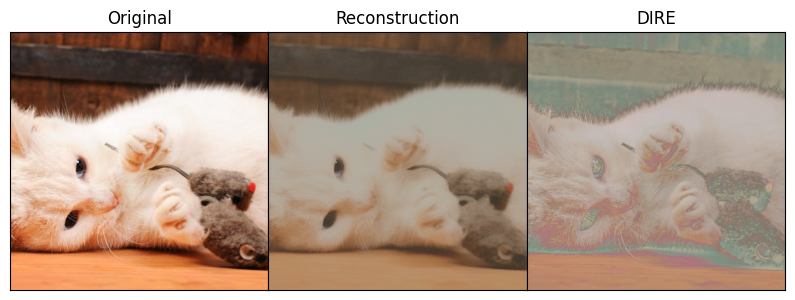

In [11]:
plt.rcParams["figure.figsize"]=10,20
img = inverse_transform(imgs[0])
reconstruction = inverse_transform(reconstructions[0])
dire0 = inverse_transform(dire[0])

plt.figure(dpi=900)
f, axs = plt.subplots(1,3) 
axs[0].imshow(img)
axs[1].imshow(reconstruction)
axs[2].imshow(dire0)

for i in range(3):
      axs[i].xaxis.set_visible(False)
      axs[i].yaxis.set_visible(False)

axs[0].set_title("Original")
axs[1].set_title("Reconstruction")
axs[2].set_title("DIRE")
plt.subplots_adjust(wspace=0, hspace=0)

<Figure size 18000x18000 with 0 Axes>

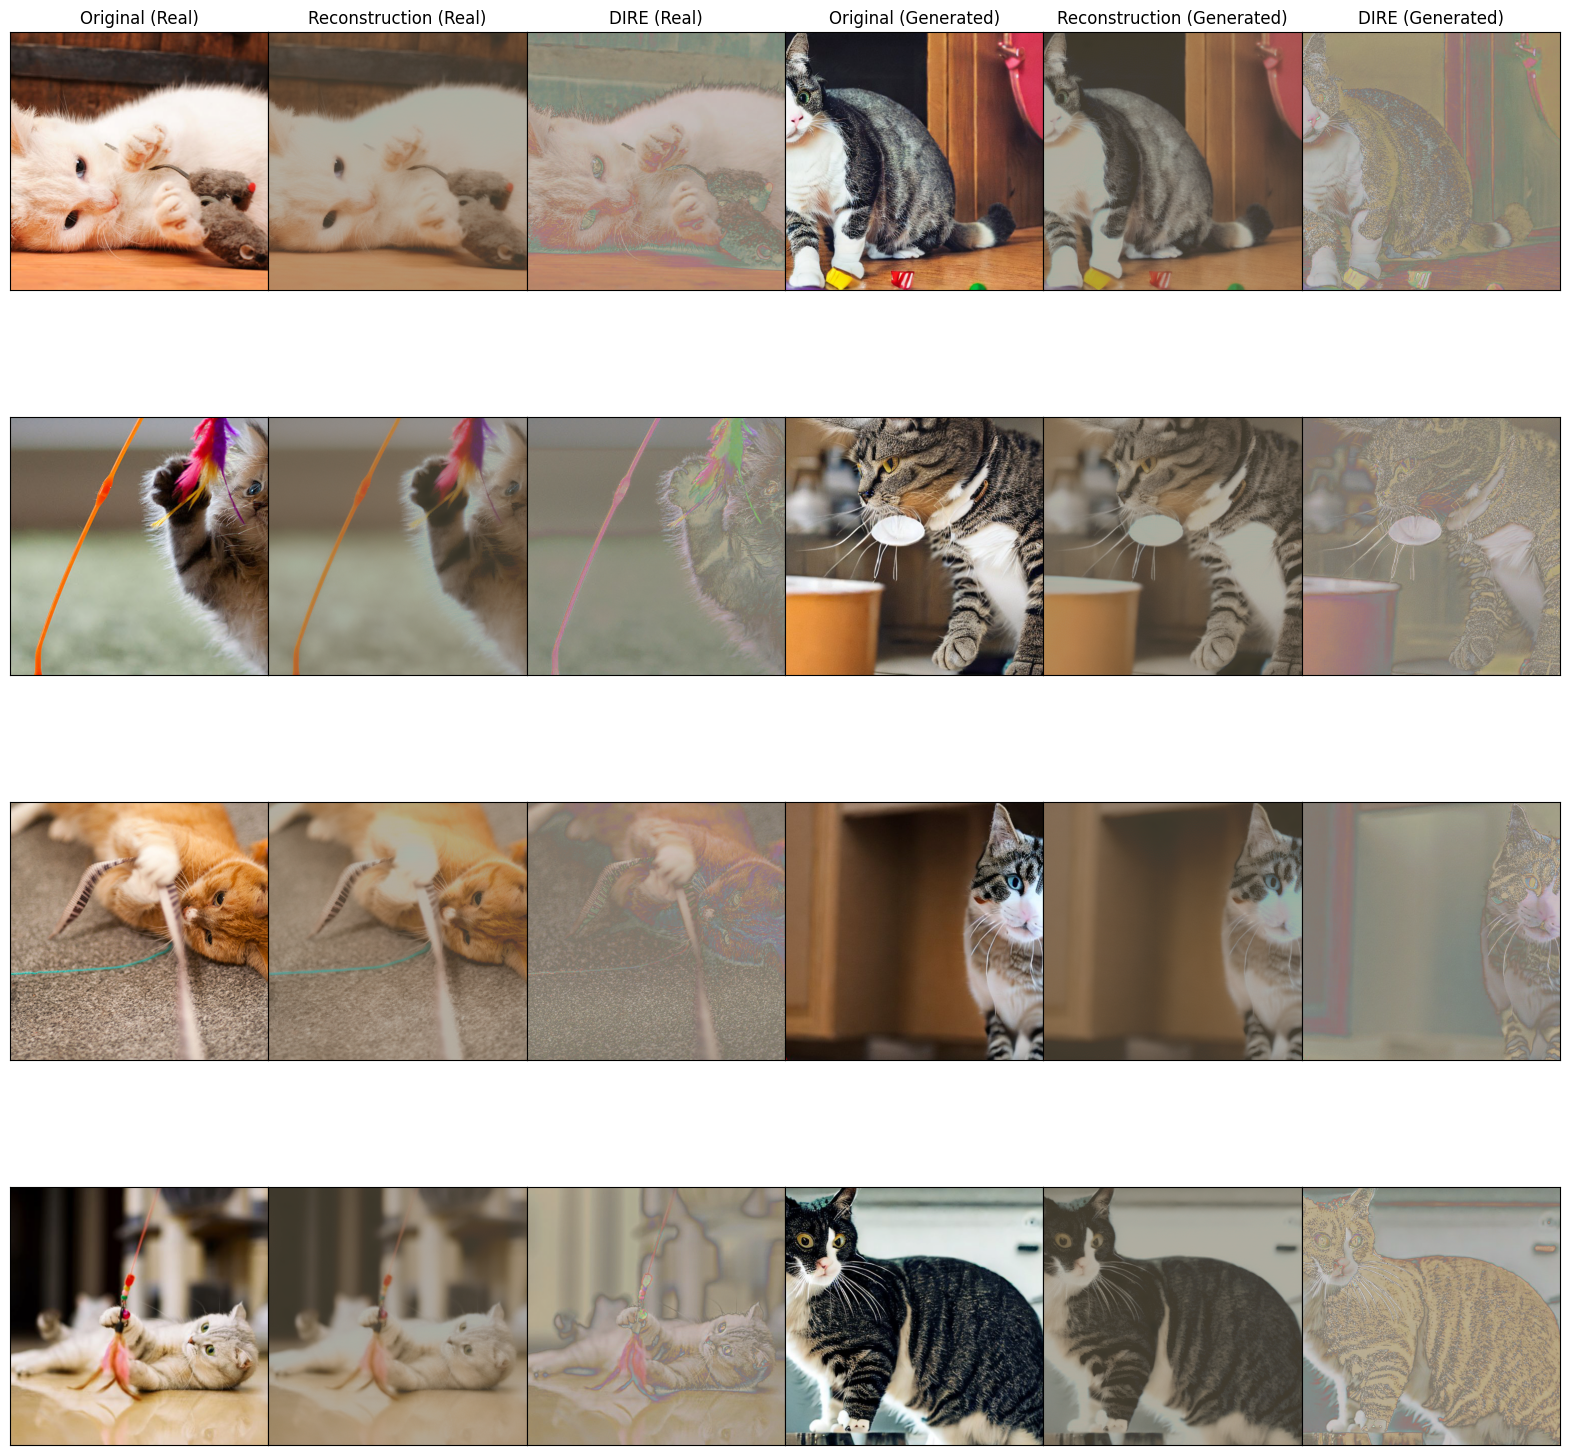

In [10]:
plt.rcParams["figure.figsize"]=20,20
plt.figure(dpi=900)
f, axs = plt.subplots(4,6) 

for i in range(4):
    axs[i, 0].imshow(inverse_transform(imgs[i]))
    axs[i, 1].imshow(inverse_transform(reconstructions[i]))
    axs[i, 2].imshow(inverse_transform(dire[i]))
    axs[i, 3].imshow(inverse_transform(imgs[i + 4]))
    axs[i, 4].imshow(inverse_transform(reconstructions[i + 4]))
    axs[i, 5].imshow(inverse_transform(dire[i + 4]))
    for j in range(6):
      axs[i, j].xaxis.set_visible(False)
      axs[i, j].yaxis.set_visible(False)
  
axs[0,0].set_title("Original (Real)")
axs[0,1].set_title("Reconstruction (Real)")
axs[0,2].set_title("DIRE (Real)")
axs[0,3].set_title("Original (Generated)")
axs[0,4].set_title("Reconstruction (Generated)")
axs[0,5].set_title("DIRE (Generated)")
plt.subplots_adjust(wspace=0, hspace=0)
f.show()